# Two parallel noncomunicating zones in a reservoir
I'm injecting the seawater into a reservoir via a long horizontal well. The injectivity is better in some areas. I assign a larger injection rate to the 1D model for that zone, and a lower injection rate to the rest of the well, which is modelled again with a 1D model.

In [2]:
include("../FractionalFlow/FractionalFlow.jl")
using PyPlot, Dierckx, SetPyPlot, Roots
import CoolProp
FF = FractionalFlow
setrcparam()

┌ Info: Precompiling ProgressMeter [92933f4c-e287-5a05-a399-4b506db050ca]
└ @ Base loading.jl:1186
┌ Info: Precompiling Optim [429524aa-4258-5aef-a3af-852621145aeb]
└ @ Base loading.jl:1186
┌ Info: Recompiling stale cache file C:\Users\aliak\.julia\compiled\v1.1\SetPyPlot\Rkvls.ji for SetPyPlot [d6c70c59-9b85-50b1-926c-19fb5cf24e7d]
└ @ Base loading.jl:1184
┌ Warning: Package SetPyPlot does not have PyPlot in its dependencies:
│ - If you have SetPyPlot checked out for development and have
│   added PyPlot as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with SetPyPlot
└ Loading PyPlot into SetPyPlot from project dependency, future warnings for SetPyPlot are suppressed.


In [3]:
]add ProgressMeter 

 Resolving package versions...
  Updating `C:\Users\aliak\.julia\environments\v1.1\Project.toml`
 [no changes]
  Updating `C:\Users\aliak\.julia\environments\v1.1\Manifest.toml`
 [no changes]


In [4]:
function w_comp(p_in, p_out)
    eta_comp=0.7
    eta_driver=0.9
    eta_pp=0.4
    comp_ratio = 3.5     
    w_min=0.0

    T_comp=40.0+273.15 # K gas enters the compressor
    n_stage = Int(round(log(p_out/p_in)/log(comp_ratio)))
    p_comp=zeros(n_stage+1)
    p_comp[1]=p_in
    p_comp[end]=p_out
    for i in 2:n_stage
        p_comp[i]=p_comp[i-1]*comp_ratio
    end
    for i in 1:n_stage
        S_in=CoolProp.PropsSI("SMOLAR", "T", T_comp, "P", p_comp[i], "CO2") # molar entropy J/(mol.K)
        H_in=CoolProp.PropsSI("HMOLAR", "T", T_comp, "P", p_comp[i], "CO2") # molar enthalpy J/mol
        T_out=CoolProp.PropsSI("T", "SMOLAR", S_in, "P", p_comp[i+1], "CO2")
        H_out=CoolProp.PropsSI("HMOLAR", "T", T_out, "P", p_comp[i+1], "CO2") # molar enthalpy J/mol
        w_min+=H_out-H_in # J/mol
    end
    return w_min/(eta_comp*eta_driver*eta_pp)
end

w_comp (generic function with 1 method)

In [5]:
krw0_ww = 0.271636
krw0_ow = 0.226423
kro0_ww = 0.640774
kro0_ow = 0.53222
nw_ww = 3.74488
# nw_ow= 3.81109
# no_ww = 1.93454
nw_ow= 3.0
no_ww = 2.0
no_ow= 2.0844
sor_ww=0.333829
sor_ow=0.40325
sor_mw=0.1
swc_ww=0.212
swc_ow=0.212

mu_oil = 0.6e-3 # no CO2
mu_oil_CO2 = 0.25e-3 # with 60% CO2
mu_water = 0.45e-3 # constant


u_inj_slow = 0.03e-5 # [m/s]
pv_inj_fast = 2.0
pv_inj_slow = 7.0
A_fast = 0.7 # normalized to a total injection area of 1.0
A_slow = 1-A_fast # normalized to a total injection area of 1.0
eq_const = 0.3
L_res = 100 # [m]
poros = 0.3 # [-]
k = 0.001e-12 # [m2]
p_back = 250e5

2.5e7

In [6]:
u_inj_slow*24*3600

0.02592

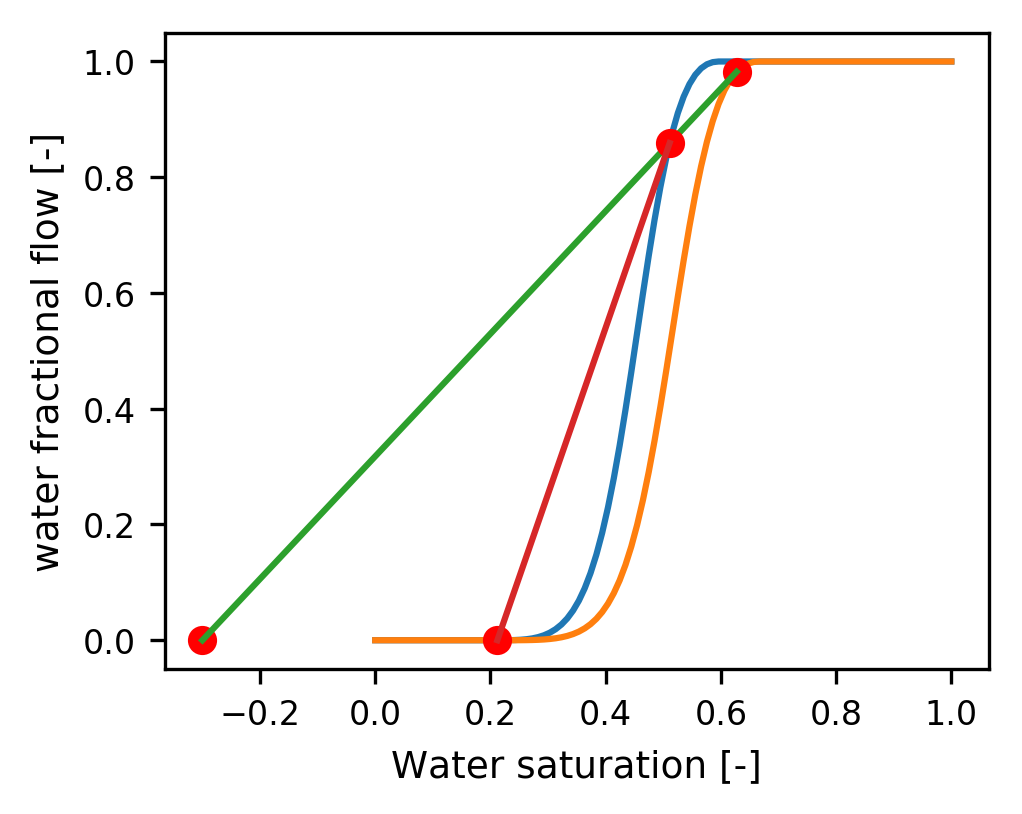

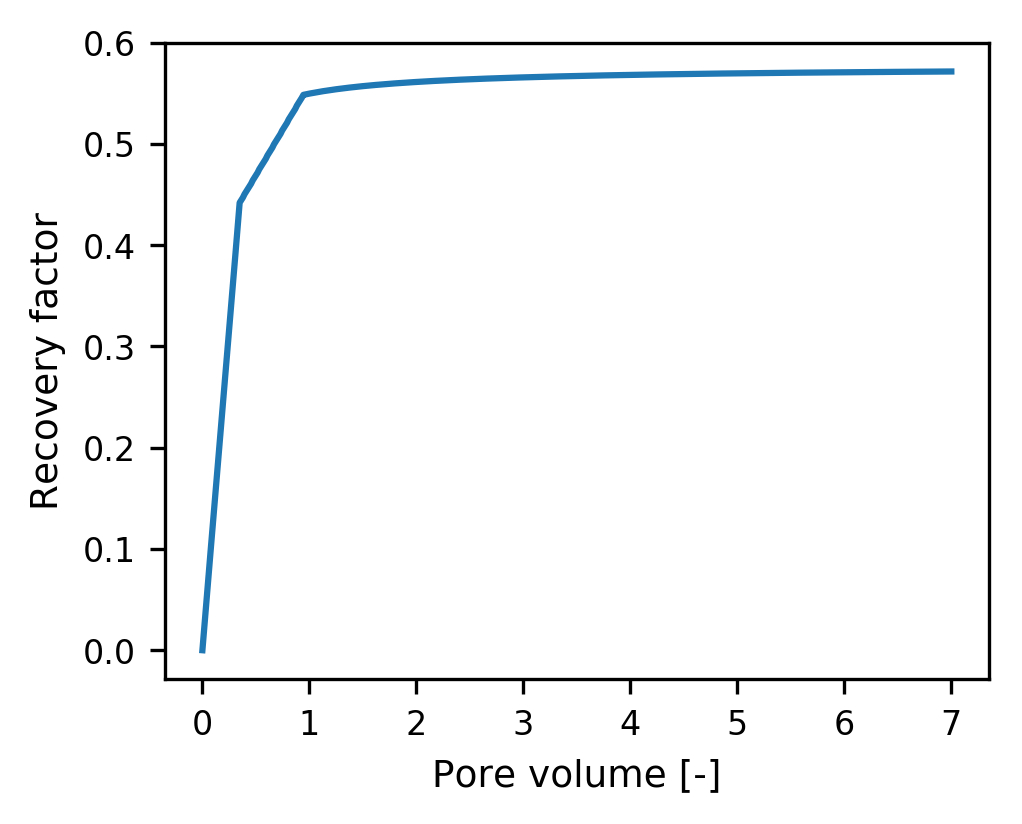

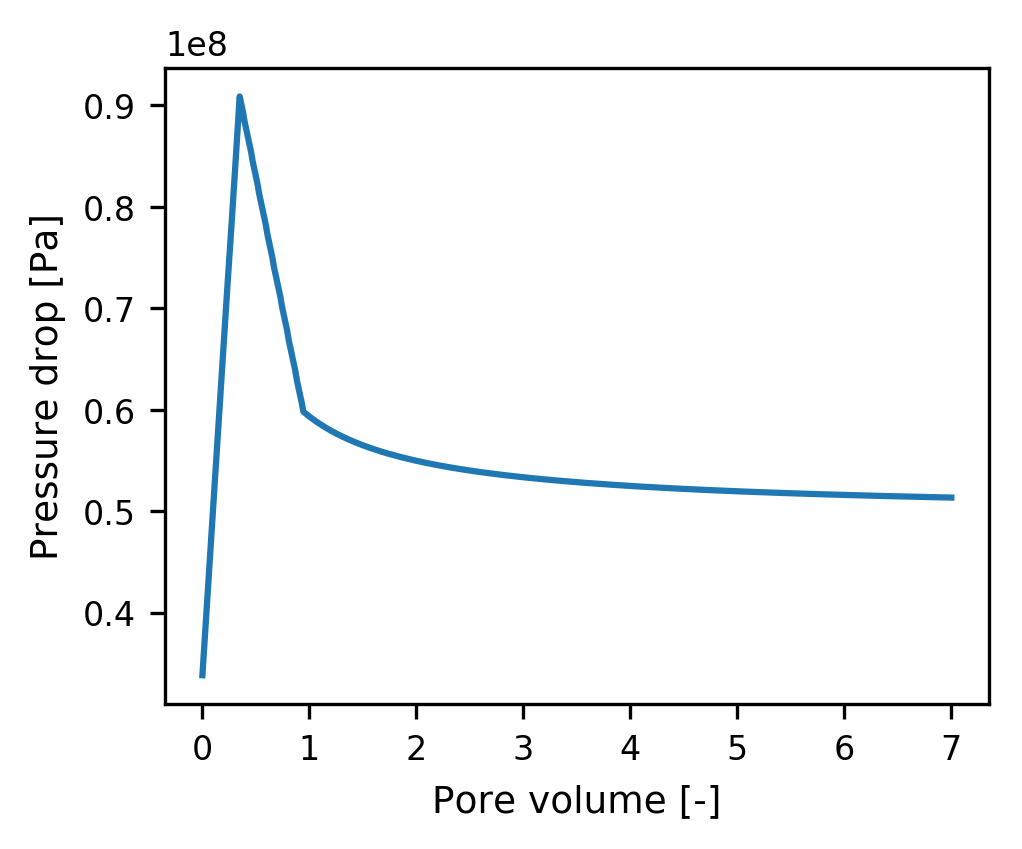

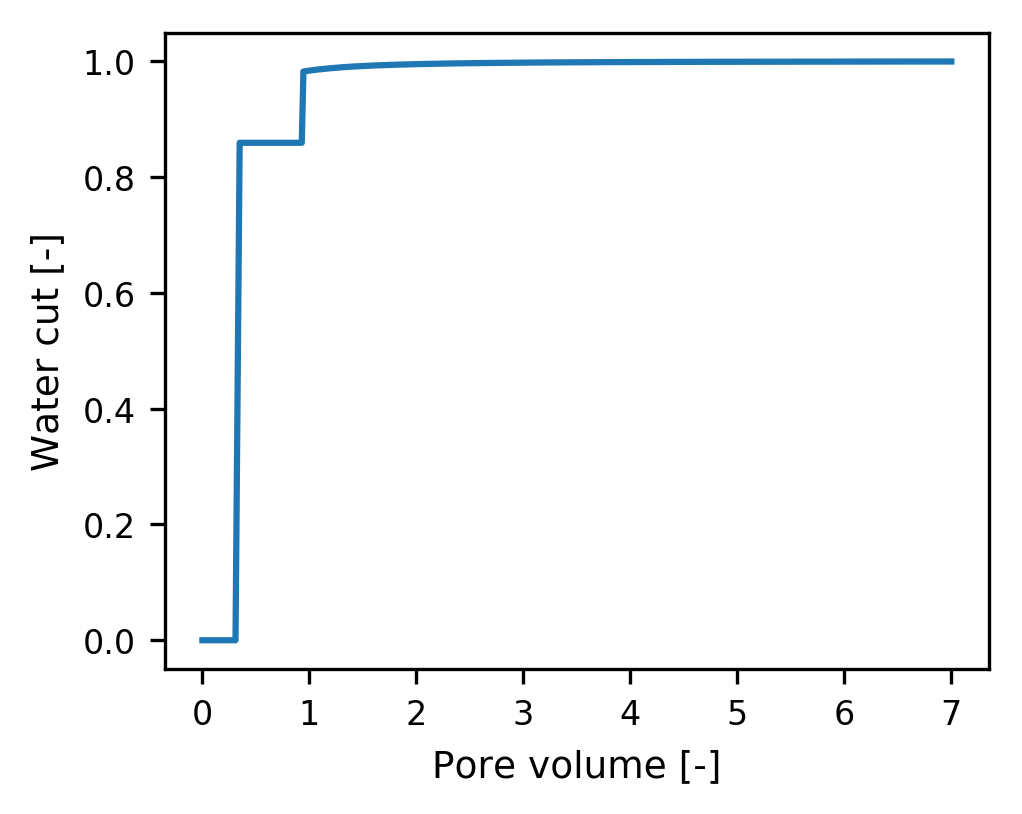

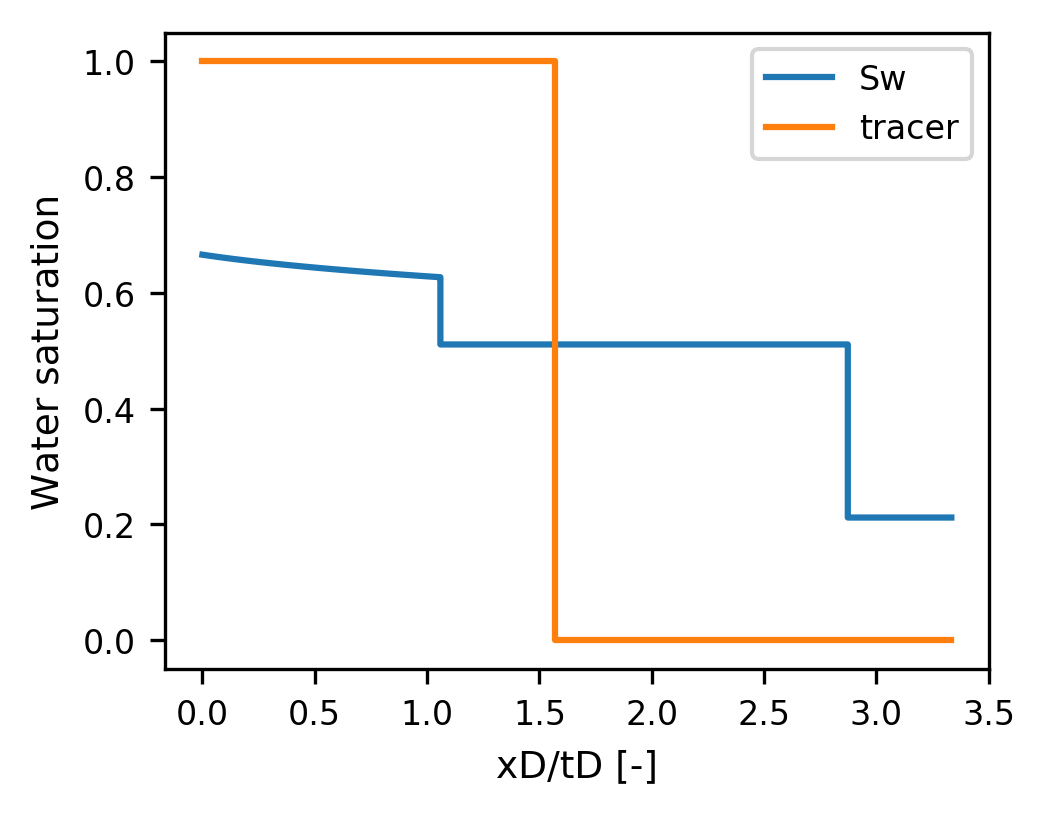

┌ Info: difficulty finding the shock front saturation range!
└ @ Main.FractionalFlow D:\projects\github\peteng\analytical\FractionalFlow\FractionalFlow.jl:401
┌ Info: difficulty finding the shock front saturation range!
└ @ Main.FractionalFlow D:\projects\github\peteng\analytical\FractionalFlow\FractionalFlow.jl:401


PyObject <matplotlib.legend.Legend object at 0x0000000032003E80>

In [7]:
fluids_hs = FF.oil_water_fluids(mu_water=mu_water, mu_oil=mu_oil)
fluids_ls = FF.oil_water_fluids(mu_water=mu_water, mu_oil=mu_oil)
rel_perms_hs = FF.oil_water_rel_perms(krw0=krw0_ow, kro0=kro0_ow, 
        swc=swc_ow, sor=sor_ow, nw=nw_ow, no = no_ow)
rel_perms_ls = FF.oil_water_rel_perms(krw0=krw0_ww, kro0=kro0_ww, 
        swc=swc_ww, sor=sor_ww, nw=nw_ww, no = no_ww)
# rel_perms_hs = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
#         swc=0.15, sor=0.4, nw=2.0, no = 2.0)
# rel_perms_ls = FF.oil_water_rel_perms(krw0=0.35, kro0=0.95, 
#         swc=0.15, sor=0.35, nw=2.0, no = 2.0)
core_flood = FF.core_flooding(u_inj=u_inj_slow, pv_inject=pv_inj_slow, p_back=p_back, sw_init=0.2, sw_inj=1.0, rel_perms=rel_perms_hs)

core_props = FF.core_properties(L=L_res, φ=poros, k=k)

ls_res_slow = FF.single_ion_adsorption_water_flood(core_props, fluids_ls, fluids_hs, rel_perms_hs, 
        rel_perms_ls, core_flood, eq_const)

FF.visualize(ls_res_slow)

The above figure shows the water cut in each zone. I need to add them together based on the total flow rate in each zone and plot the final value versus time. I need to know the total injection rate, the total surface area of each zone, and the water cut versus time. Then I calculate the new water cut versus time by calculating the total flow of oil and normalizing it.

## Solvent injection: DME example
One necessary detail is the volumetric partition coefficient that is needed for finding the analytical solution. It can be done by doing some thermodynamic magic for finding the partial molar volumes of DME in the aqueous and in the oleic phase.  
I've done it in another file, because it is boring for everybody else (not me, I love thermodynamics). The result is here. I have also shown the molar and mass partition coefficients

low sal sw_shock = 0.842836690267015
low sal breakthrough time = 1.3654081679391532


┌ Info: difficulty finding the shock front saturation range!
└ @ Main.FractionalFlow D:\projects\github\peteng\analytical\FractionalFlow\FractionalFlow.jl:401


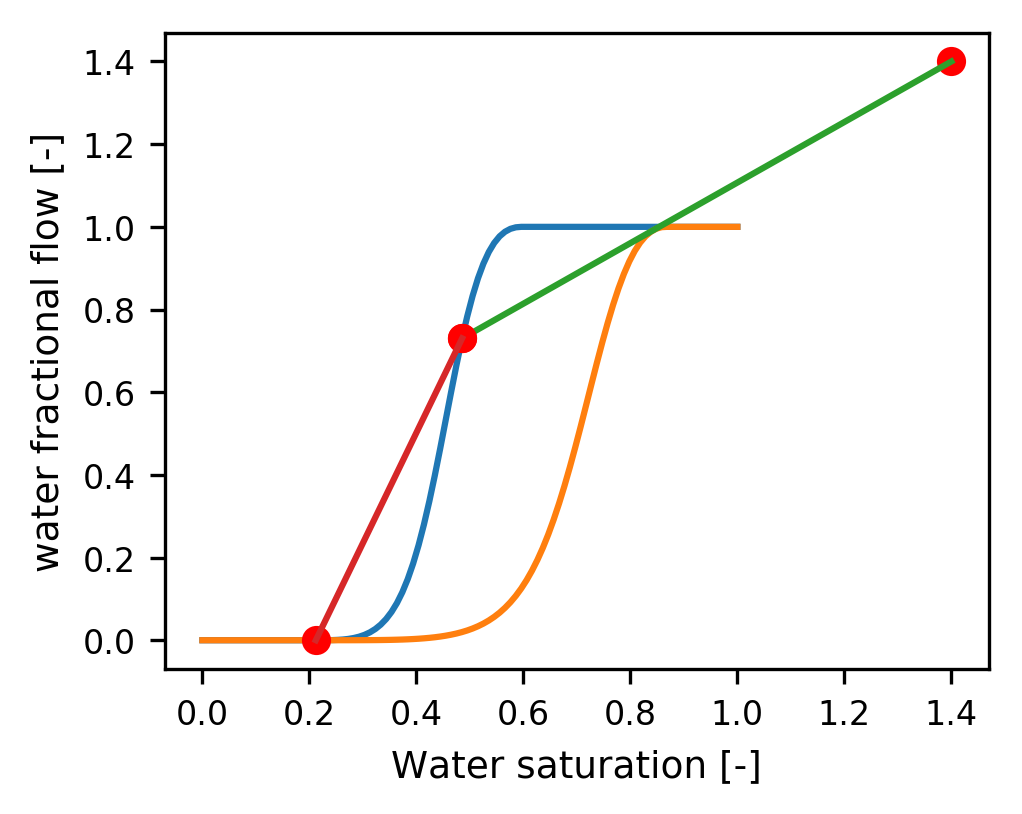

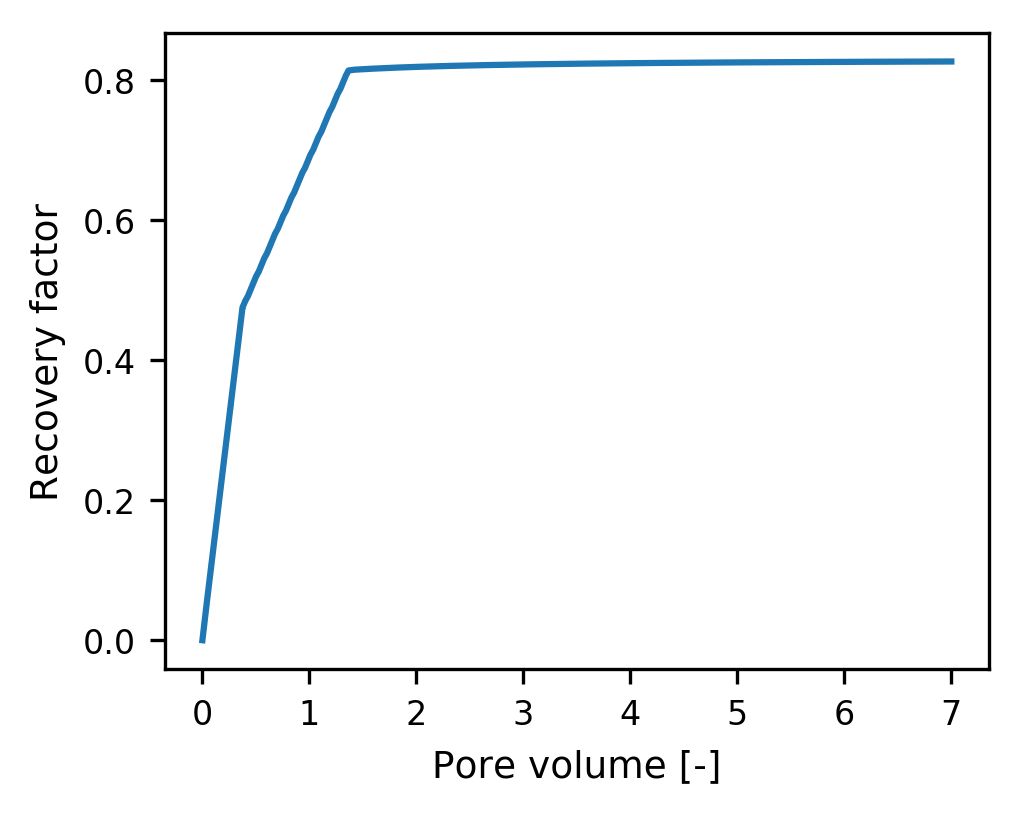

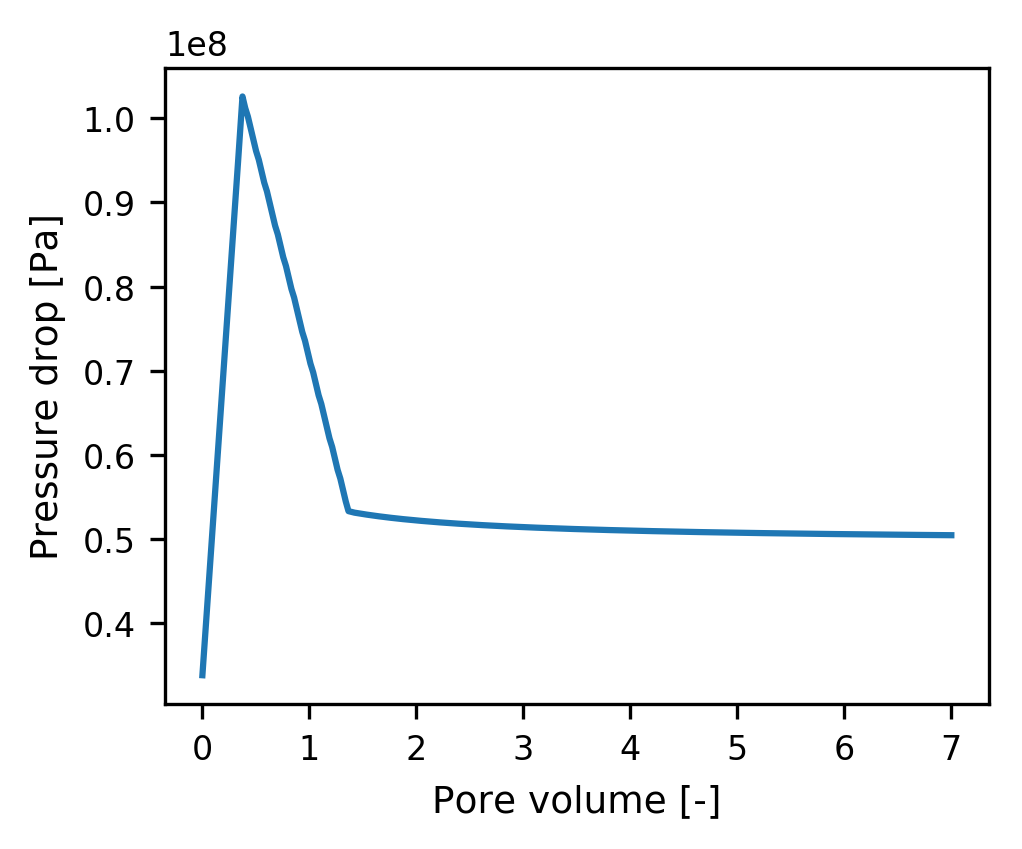

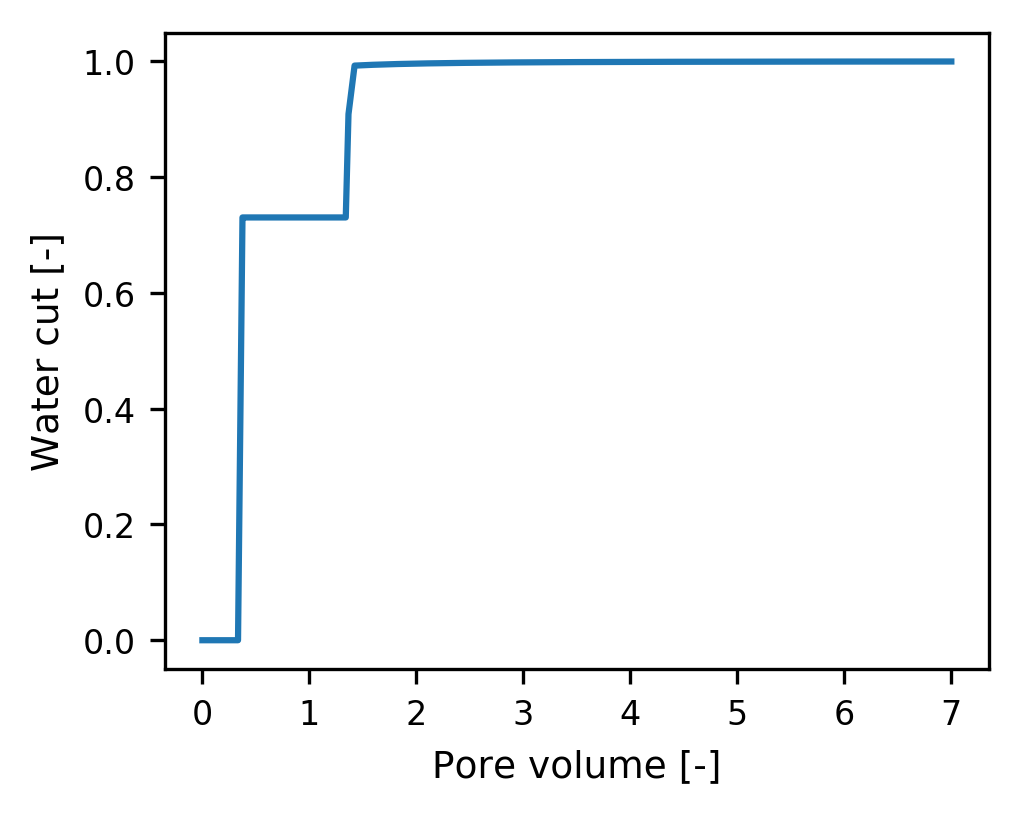

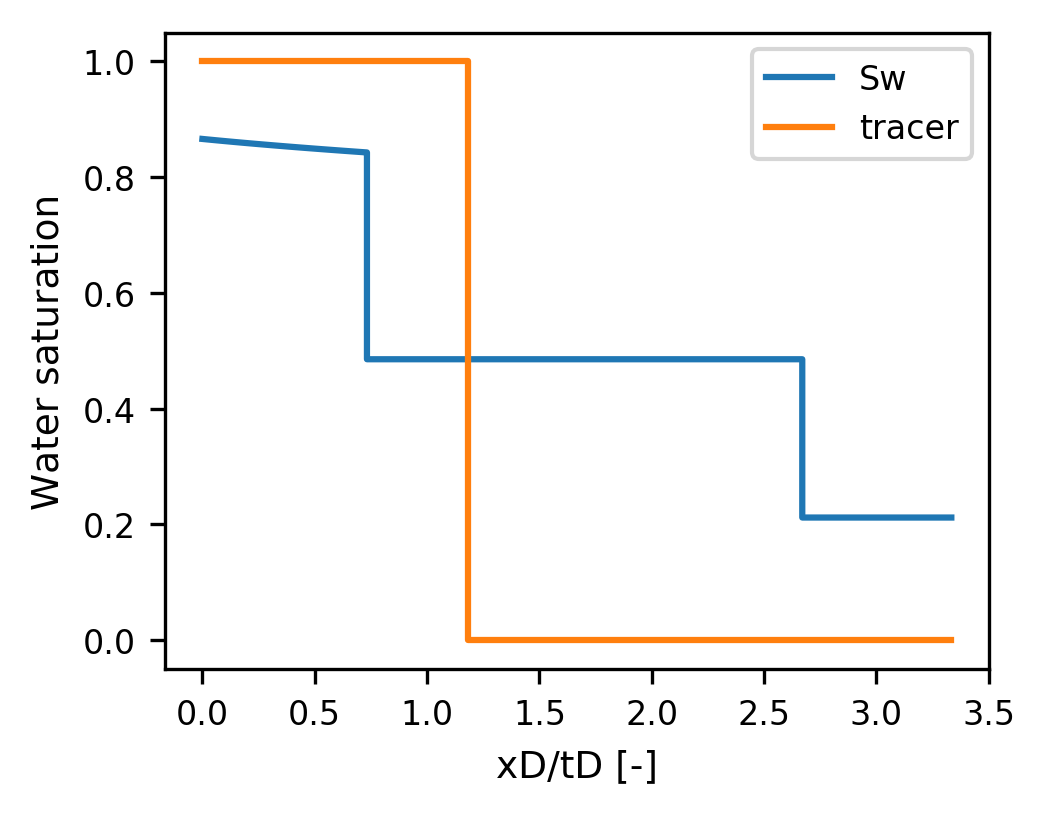

co2 breakthrough time is 1.3654081679391533e8

┌ Info: difficulty finding the shock front saturation range!
└ @ Main.FractionalFlow D:\projects\github\peteng\analytical\FractionalFlow\FractionalFlow.jl:401


PyObject <matplotlib.legend.Legend object at 0x0000000032711400>

In [8]:

kro0_ww = 0.840774
sor_ww=0.133829

fluids_oil_water = FF.oil_water_fluids(mu_water=mu_water, mu_oil=mu_oil)
fluids_solvent = FF.oil_water_fluids(mu_water=mu_water, mu_oil=mu_oil_CO2)
# rel_perms_oil_water = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
#     swc=0.15, sor=0.2, nw=2.0, no = 2.0)
# rel_perms_solvent = FF.oil_water_rel_perms(krw0=0.4, kro0=0.9, 
# swc=0.15, sor=0.05, nw=2.0, no = 2.0)
rel_perms_oil_water = FF.oil_water_rel_perms(krw0=krw0_ow, kro0=kro0_ow, 
        swc=swc_ow, sor=sor_ow, nw=nw_ow, no = no_ow)
rel_perms_solvent = FF.oil_water_rel_perms(krw0=krw0_ww, kro0=kro0_ww, 
        swc=swc_ww, sor=sor_ww, nw=nw_ww, no = no_ww)
core_flood = FF.core_flooding(u_inj=u_inj_slow, pv_inject=pv_inj_slow, p_back=p_back, sw_init=0.2, sw_inj=1.0, rel_perms=rel_perms_hs)
# core_props = FF.core_properties()
K_eq = 3.5
sol_res = FF.water_soluble_solvent_flood(core_props, fluids_solvent, fluids_oil_water, 
    rel_perms_oil_water, rel_perms_solvent, core_flood, K_eq)
FF.visualize(sol_res)

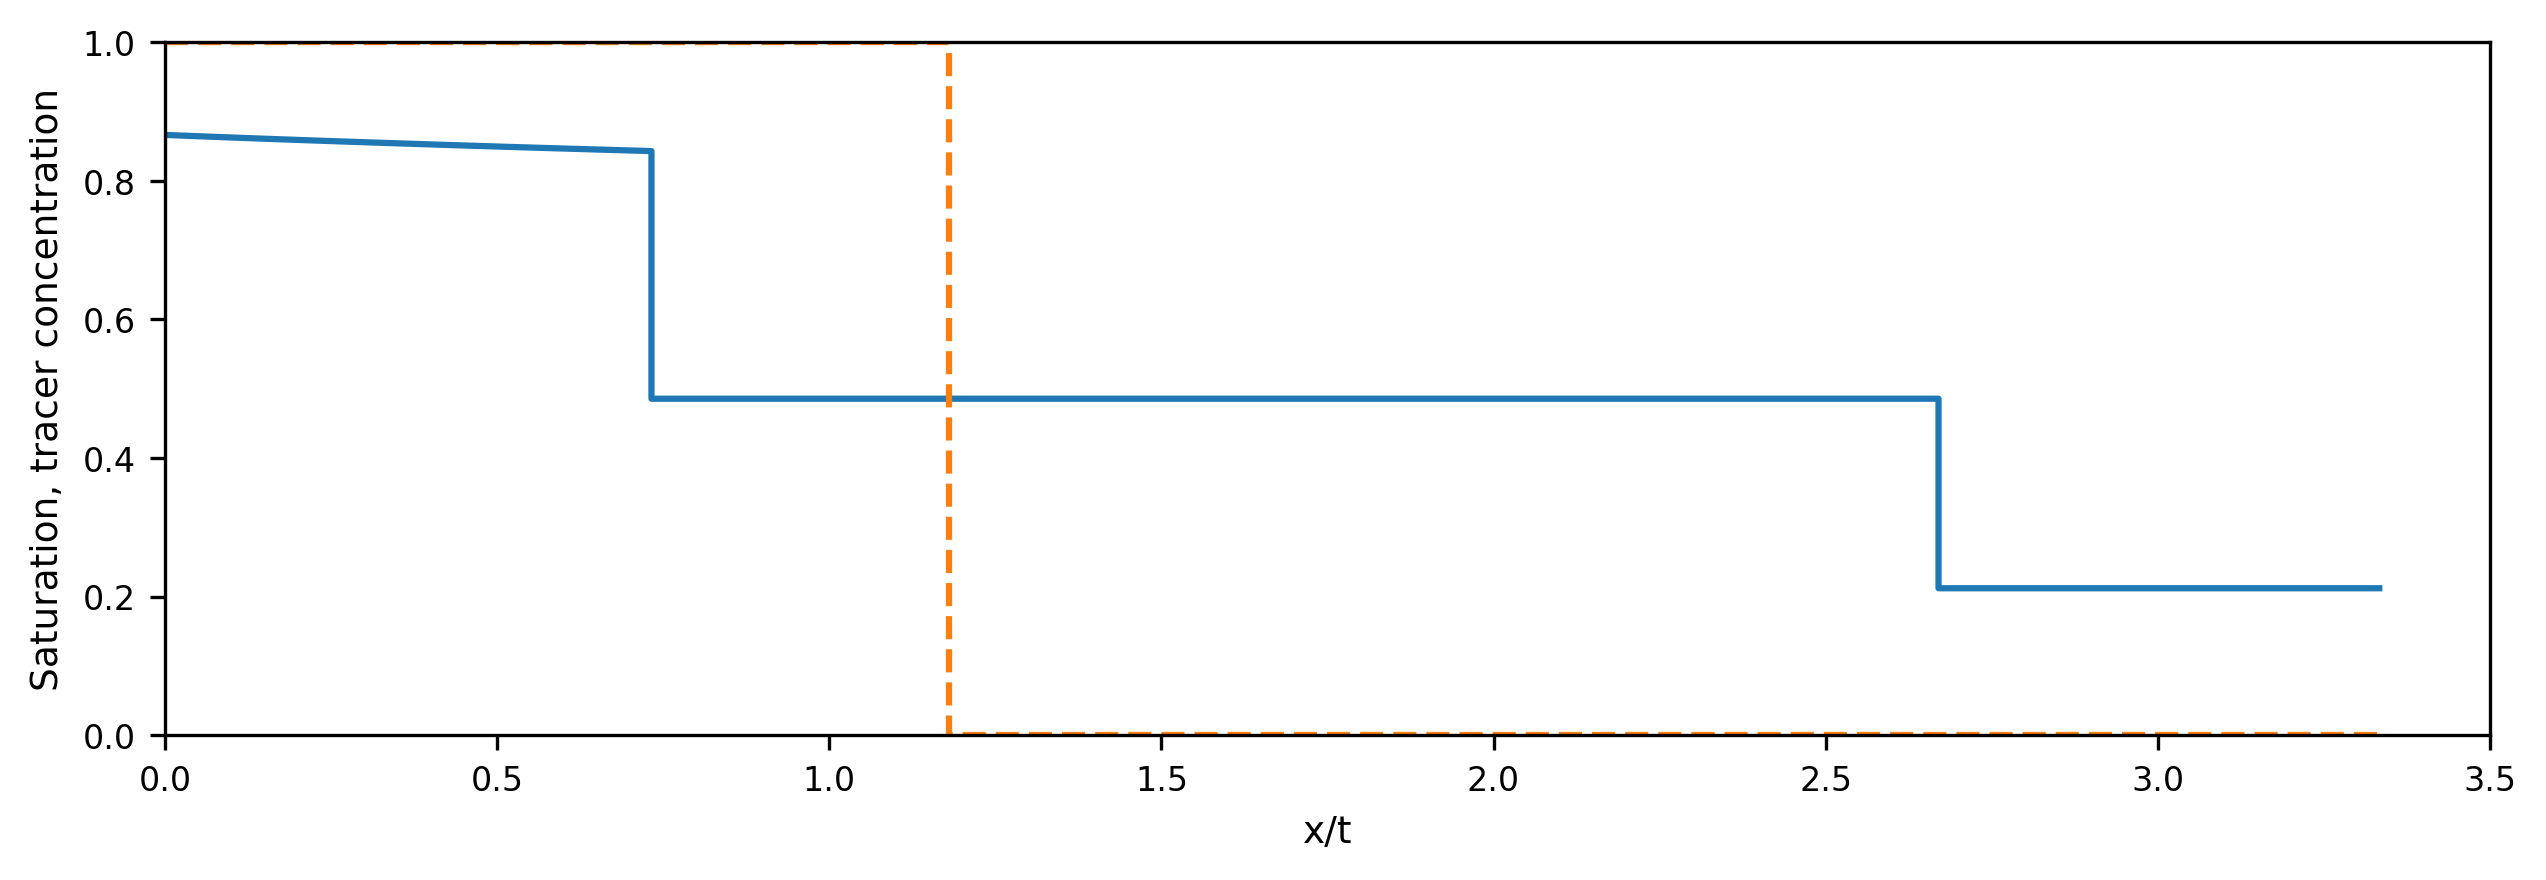

In [24]:
figure(figsize=(10,3))
plot(sol_res.saturation_profile_xt[:,1], sol_res.saturation_profile_xt[:,2])
plot(sol_res.tracer_profile_xt[:,1], sol_res.tracer_profile_xt[:,2], "--")
xlabel("x/t")
ylabel("Saturation, tracer concentration")
axis([0,3.5,0,1])
savefig("sat_profile.svg")

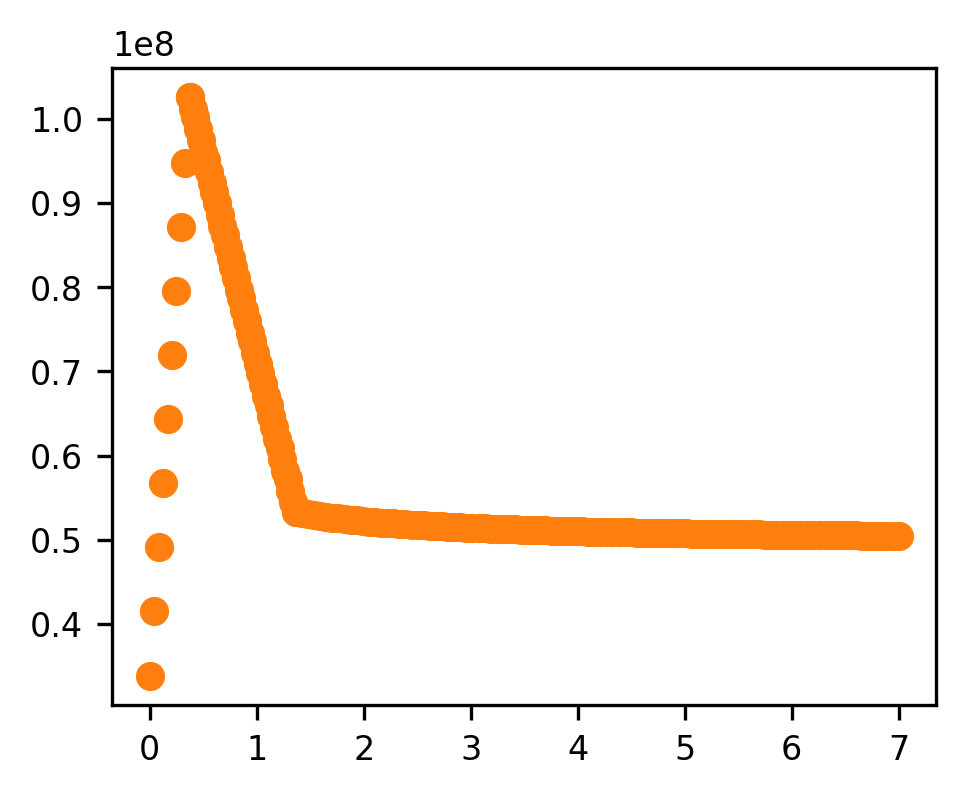

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000032838D68>
 PyObject <matplotlib.lines.Line2D object at 0x0000000032838EF0>

In [9]:
dp = Spline1D(sol_res.dp_pv[:,1], sol_res.dp_pv[:,2], k=1, bc="nearest")
R = Spline1D(sol_res.recovery_pv[:,1], sol_res.recovery_pv[:,2])
WC = Spline1D(sol_res.water_cut_pv[:,1], sol_res.water_cut_pv[:,2])
pv = collect(range(0, 2, length = 100))
plot(pv, dp(pv), sol_res.dp_pv[:,1], sol_res.dp_pv[:,2], "o")

In [10]:
ind_max = findfirst(sol_res.dp_pv[2:end,1].>2)
water_cut = sol_res.water_cut_pv[1:ind_max,2]
t_inj = sol_res.water_cut_pv[1:ind_max,1] # PV
t_end = t_inj[end]
pv_bt = 1.3654081679391532 # PV of CO2 breakthrough
pv_tot = t_inj[end]

1.9914739270570252

# Exergy analysis
In this section, I perform a very quick and dirty exergy analysis for the paper.
work is calculated per unit injected volume; we assume that dissolution of CO2 in water does not change its density (only for the mass balance).

Injection: 1 m3/s

In [11]:
# basis
q_inj = 1.0 # PV/time carbonated water injection rate
eta_driver=0.9
eta_pp=0.4
eta_pump = 0.8

# input numbers
Ex_trans_CO2 = 1000 # [kJ/kg CO2]
Ex_capture = 4000 # [kJ/kg CO2]
Ex_transport = 1000 # [kJ/kg CO2]
Ex_capture_atm = 2.0*Ex_capture # 50% higher than post combustion capture
Ex_oil = 10*400+22*100 # [kJ/mol oil] Decane
em_pp = 0.044/500
MW_oil = 0.012*10+22.0*0.001 # [kg/mol] 
MW_CO2 = 0.044 # kg/mol
ρ_oil = 800 # [kg/m3]

# exergy analysis for an injection time of 2.0 PV
pv_CO2_bt = 1.3654081679391532 # PV CO2 breakthrough
c_CO2_inj = 0.6 # kmol CO2/m3 water
c_CO2_oil = K_eq*c_CO2_inj # kmol CO2/m3 oil

p_inj = sol_res.dp_pv[1:ind_max,1].+p_back # Pa injection pressure
p_head = 1e5 # pressure at the wellhead

n_CO2 = q_inj*c_CO2_inj*1000 # mol/s CO2
w_comp_real = w_comp.(p_head, p_inj) # J/s/mol CO2
w_pump = q_inj*(p_inj.-p_head)./(eta_pump*eta_driver*eta_pp) # J/s

oil_flow = q_inj.*(1.0 .- water_cut) # m^3/s oil flow

# total_oil = FF.trapz(t_inj, oil_flow) # m^3 oil produced
total_oil = sol_res.recovery_pv[ind_max,2]*(1-0.2)

init_oil = 1-0.2
init_water = 0.2

remaining_oil = (1-sol_res.recovery_pv[ind_max,2])*(1-0.2) # fraction of pore volume
total_CO2_stored = remaining_oil*K_eq*c_CO2_inj+(1-remaining_oil)*c_CO2_inj # kmol CO2 stored in the reservoir

total_oil_CO2 = 10*total_oil*ρ_oil/MW_oil/1000 # kmol CO2 of oil itself
CO2_penalty = (Ex_capture+Ex_transport)*MW_CO2*c_CO2_inj*pv_tot*em_pp/MW_CO2/1000 # kmol CO2

total_exergy_required = FF.trapz(t_inj, w_pump.+w_comp_real.*c_CO2_inj)/1000+
                        (Ex_capture+Ex_transport)*MW_CO2*c_CO2_inj*pv_tot # kJ
total_oil_exergy = total_oil*ρ_oil/MW_oil*Ex_oil # kJ

# CO2 stored:
storage_fraction = (total_CO2_stored-CO2_penalty)/total_oil_CO2

total_exergy_required_atm = FF.trapz(t_inj, w_pump.+w_comp_real.*c_CO2_inj)/1000+
                        (Ex_capture_atm+Ex_transport)*MW_CO2*c_CO2_inj*pv_tot # kJ

172726.09314817365

# Postcombustion

In [12]:
total_exergy_required/total_oil_exergy, (total_CO2_stored-CO2_penalty)/total_oil_CO2

(0.007537709007312363, 0.022121993282675025)

In [13]:
1-0.007537709007312363

0.9924622909926877

In [14]:
(CO2_penalty)/total_oil_CO2

1.4242320305314949e-5

In [15]:
Ex_capture/MW_CO2*c_CO2_inj*pv_tot

108625.85056674683

# atm capture

In [16]:
total_exergy_required_atm/total_oil_exergy, (total_CO2_stored)/total_oil_CO2

(0.007546897601057728, 0.02213623560298034)